<a href="https://colab.research.google.com/github/jafetimbre/ms-school-stuff/blob/master/image-processing/face_swap/swap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [262]:
import cv2
import numpy as np
from urllib.request import urlopen, urlretrieve
import matplotlib.pyplot as plt
import dlib

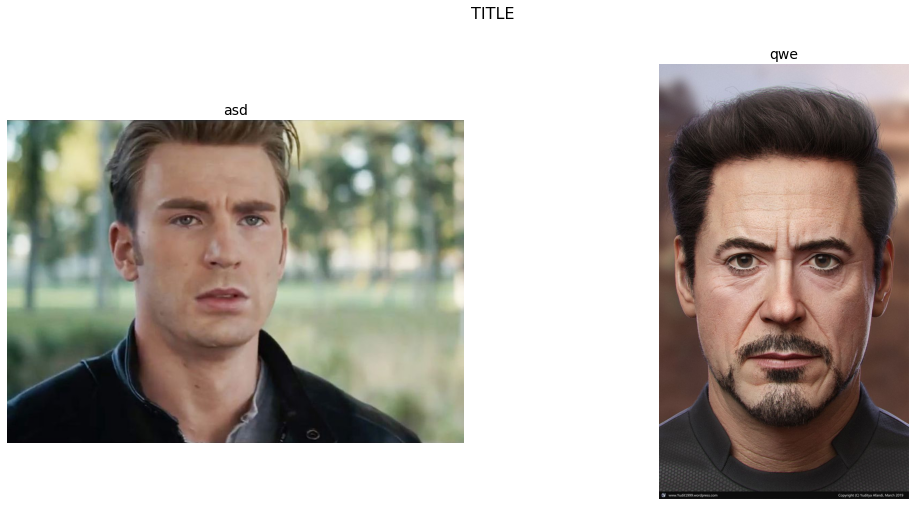

In [256]:
req = urlopen("https://raw.githubusercontent.com/jafetimbre/ms-school-stuff/master/image-processing/face_swap/res/steve_rogers.jpg")
arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
steve = cv2.imdecode(arr, -1)

req = urlopen("https://raw.githubusercontent.com/jafetimbre/ms-school-stuff/master/image-processing/face_swap/res/tony_stark.jpg")
arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
tony = cv2.imdecode(arr, -1)


fig, axs = plt.subplots(1, 2, figsize=(18,8))
fig.suptitle("TITLE", fontsize=16)
titles = [ "asd", "qwe"]
for i, im in enumerate([steve, tony]):
    axs[i].axis("off")
    axs[i].set_title(titles[i], fontsize=14)
    axs[i].imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))

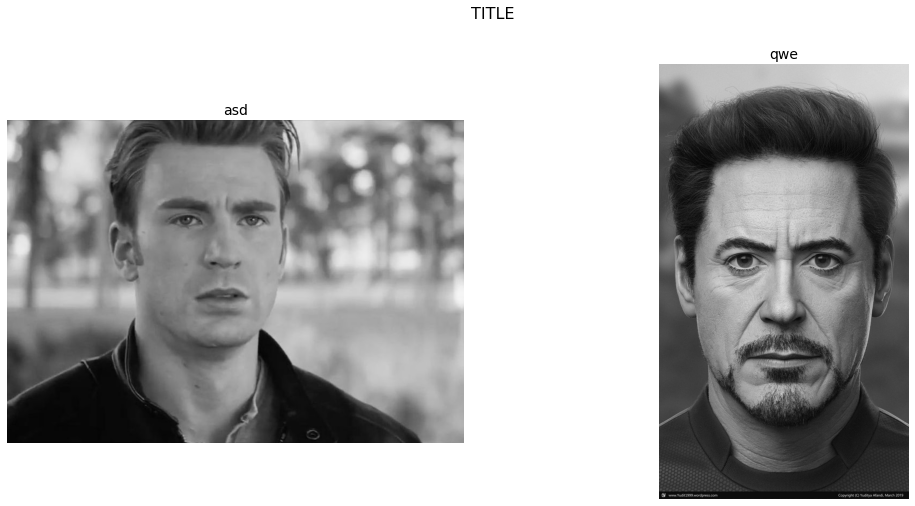

In [258]:
steve_gray = cv2.cvtColor(steve, cv2.COLOR_BGR2GRAY)
tony_gray = cv2.cvtColor(tony, cv2.COLOR_BGR2GRAY)

fig, axs = plt.subplots(1, 2, figsize=(18,8))
fig.suptitle("TITLE", fontsize=16)
titles = [ "asd", "qwe"]
for i, im in enumerate([steve_gray, tony_gray]):
    axs[i].axis("off")
    axs[i].set_title(titles[i], fontsize=14)
    axs[i].imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))

In [260]:
height, width = steve_gray.shape
mask = np.zeros((height, width), np.uint8)
height, width, channels = tony.shape

In [264]:
urlretrieve('https://github.com/jafetimbre/ms-school-stuff/raw/master/image-processing/face_swap/res/shape_predictor_68_face_landmarks.dat', 'shape_predictor_68_face_landmarks.dat')
PREDICTOR_PATH = './shape_predictor_68_face_landmarks.dat'

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(PREDICTOR_PATH)

In [268]:
def get_landmarks(landmarks, landmarks_points):
  for n in range(68):
      x = landmarks.part(n).x
      y = landmarks.part(n).y
      landmarks_points.append((x, y))

In [265]:
rect = detector(steve_gray)[0]

landmarks = predictor(steve_gray, rect)
landmarks_points = [] 

get_landmarks(landmarks, landmarks_points)
points = np.array(landmarks_points, np.int32)

convexhull = cv2.convexHull(points)

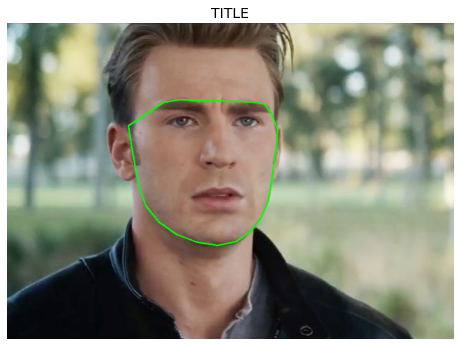

In [278]:
steve_cpy = steve.copy()

plt.figure(figsize = (8, 8))
plt.axis("off")
plt.title("TITLE", fontsize=14)
plt.imshow(cv2.cvtColor((cv2.polylines(steve_cpy, [convexhull], True, (0, 255, 0), 2)), cv2.COLOR_BGR2RGB))

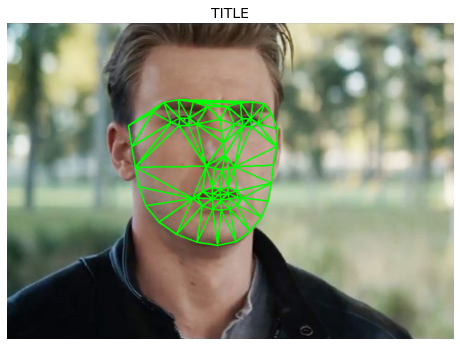

In [279]:
rect = cv2.boundingRect(convexhull)

subdiv = cv2.Subdiv2D(rect) # Creates an instance of Subdiv2D
subdiv.insert(landmarks_points) # Insert points into subdiv
triangles = subdiv.getTriangleList()
triangles = np.array(triangles, dtype=np.int32)

indexes_triangles = []
steve_cpy = steve.copy()

def get_index(arr):
    index = 0
    if len(arr[0]) != 0:
        index = arr[0][0]
    return index


for triangle in triangles :

    # Gets the vertex of the triangle
    pt1 = (triangle[0], triangle[1])
    pt2 = (triangle[2], triangle[3])
    pt3 = (triangle[4], triangle[5])
    
    # Draws a line for each side of the triangle
    cv2.line(steve_cpy, pt1, pt2, (0, 255, 0), 2,  0)
    cv2.line(steve_cpy, pt2, pt3, (0, 255, 0), 2,  0)
    cv2.line(steve_cpy, pt3, pt1, (0, 255, 0), 2,  0)

    index_pt1 = np.where((points == pt1).all(axis=1))
    index_pt1 = get_index(index_pt1)
    index_pt2 = np.where((points == pt2).all(axis=1))
    index_pt2 = get_index(index_pt2)
    index_pt3 = np.where((points == pt3).all(axis=1))
    index_pt3 = get_index(index_pt3)

    # Saves coordinates if the triangle exists and has 3 vertices
    if index_pt1 is not None and index_pt2 is not None and index_pt3 is not None:
        vertices = [index_pt1, index_pt2, index_pt3]
        indexes_triangles.append(vertices)

# Draw delaunay triangles
plt.figure(figsize = (8, 8))
plt.axis("off")
plt.title("TITLE", fontsize=14)
plt.imshow(cv2.cvtColor(steve_cpy, cv2.COLOR_BGR2RGB))

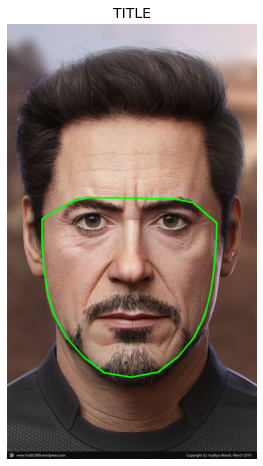

In [282]:
# Getting landmarks for the face that will have the first one swapped into
rect2 = detector(tony_gray)[0]

# This creates a with 68 pairs of integer values — these values are the (x, y)-coordinates of the facial structures 
landmarks_2 = predictor(tony_gray, rect2)
landmarks_points2 = []

# Uses the function declared previously to get a list of the landmark coordinates
get_landmarks(landmarks_2, landmarks_points2)

# Generates a convex hull for the second person
points2 = np.array(landmarks_points2, np.int32)
convexhull2 = cv2.convexHull(points2)

tony_cpy = tony.copy()

plt.figure(figsize = (8, 8))
plt.axis("off")
plt.title("TITLE", fontsize=14)
plt.imshow(cv2.cvtColor((cv2.polylines(tony_cpy, [convexhull2], True, (0,255,0), 3)), cv2.COLOR_BGR2RGB))

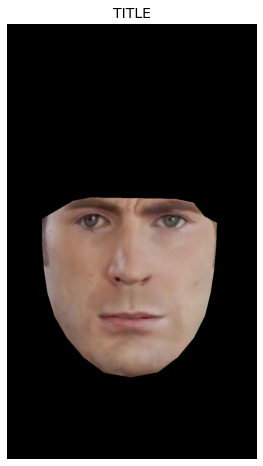

In [283]:
lines_space_new_face = np.zeros((height, width, channels), np.uint8)
body_new_face = np.zeros((height, width, channels), np.uint8)

height, width = steve_gray.shape
lines_space_mask = np.zeros((height, width), np.uint8)


for triangle in indexes_triangles:

    # Coordinates of the first person's delaunay triangles
    pt1 = landmarks_points[triangle[0]]
    pt2 = landmarks_points[triangle[1]]
    pt3 = landmarks_points[triangle[2]]

    # Gets the delaunay triangles
    (x, y, widht, height) = cv2.boundingRect(np.array([pt1, pt2, pt3], np.int32))
    cropped_triangle = steve[y: y+height, x: x+widht]
    cropped_mask = np.zeros((height, widht), np.uint8)

    # Fills triangle to generate the mask
    points = np.array([[pt1[0]-x, pt1[1]-y], [pt2[0]-x, pt2[1]-y], [pt3[0]-x, pt3[1]-y]], np.int32)
    cv2.fillConvexPoly(cropped_mask, points, 255)

    # Draws lines for the triangles
    cv2.line(lines_space_mask, pt1, pt2, 255)
    cv2.line(lines_space_mask, pt2, pt3, 255)
    cv2.line(lines_space_mask, pt1, pt3, 255)

    lines_space = cv2.bitwise_and(steve, steve, mask=lines_space_mask)

    # Calculates the delaunay triangles of the second person's face

    # Coordinates of the first person's delaunay triangles
    pt1 = landmarks_points2[triangle[0]]
    pt2 = landmarks_points2[triangle[1]]
    pt3 = landmarks_points2[triangle[2]]

    # Gets the delaunay triangles
    (x, y, widht, height) = cv2.boundingRect(np.array([pt1, pt2, pt3], np.int32))
    cropped_mask2 = np.zeros((height,widht), np.uint8)

    # Fills triangle to generate the mask
    points2 = np.array([[pt1[0]-x, pt1[1]-y], [pt2[0]-x, pt2[1]-y], [pt3[0]-x, pt3[1]-y]], np.int32)
    cv2.fillConvexPoly(cropped_mask2, points2, 255)

    # Deforms the triangles to fit the subject's face : https://docs.opencv.org/3.4/d4/d61/tutorial_warp_affine.html
    points =  np.float32(points)
    points2 = np.float32(points2)
    M = cv2.getAffineTransform(points, points2)  # Warps the content of the first triangle to fit in the second one
    dist_triangle = cv2.warpAffine(cropped_triangle, M, (widht, height))
    dist_triangle = cv2.bitwise_and(dist_triangle, dist_triangle, mask=cropped_mask2)

    # Joins all the distorted triangles to make the face mask to fit in the second person's features
    body_new_face_rect_area = body_new_face[y: y+height, x: x+widht]
    body_new_face_rect_area_gray = cv2.cvtColor(body_new_face_rect_area, cv2.COLOR_BGR2GRAY)

    # Creates a mask
    masked_triangle = cv2.threshold(body_new_face_rect_area_gray, 1, 255, cv2.THRESH_BINARY_INV)
    dist_triangle = cv2.bitwise_and(dist_triangle, dist_triangle, mask=masked_triangle[1])

    # Adds the piece to the face mask
    body_new_face_rect_area = cv2.add(body_new_face_rect_area, dist_triangle)
    body_new_face[y: y+height, x: x+widht] = body_new_face_rect_area

plt.figure(figsize = (8, 8))
plt.axis("off")
plt.title("TITLE", fontsize=14)
plt.imshow(cv2.cvtColor(body_new_face, cv2.COLOR_BGR2RGB))

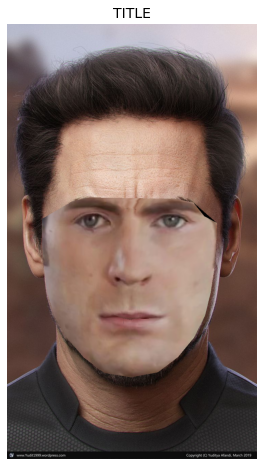

In [284]:
body_face_mask = np.zeros_like(tony_gray)
body_head_mask = cv2.fillConvexPoly(body_face_mask, convexhull2, 255)
body_face_mask = cv2.bitwise_not(body_head_mask)

body_maskless = cv2.bitwise_and(tony, tony, mask=body_face_mask)
result = cv2.add(body_maskless, body_new_face)

plt.figure(figsize = (8, 8))
plt.axis("off")
plt.title("TITLE", fontsize=14)
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))

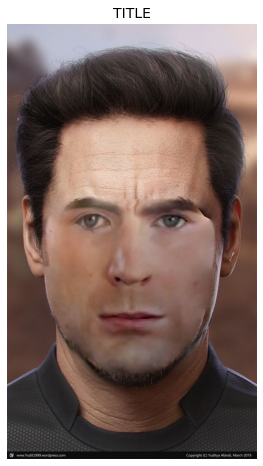

In [285]:
# Gets the center of the face for the body
(x, y, widht, height) = cv2.boundingRect(convexhull2)
center_face2 = (int((x+x+widht)/2), int((y+y+height)/2))

seamlessclone = cv2.seamlessClone(result, tony, body_head_mask, center_face2, cv2.NORMAL_CLONE)

plt.figure(figsize = (16, 8))
plt.axis("off")
plt.title("TITLE", fontsize=14)
plt.imshow(cv2.cvtColor(seamlessclone, cv2.COLOR_BGR2RGB))